In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
import numpy as np

from generate_dataset import simple_ring_dataset, randomized_ring_dataset
from models import LinearGenerator, ConvGenerator
from train_model import train_model

import matplotlib.pyplot as plt

/home/J000000000007/envs/DGBaN/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [151]:
def gaus(X, mean, sig):
    return np.exp(-(X - mean)**2 / sig**2)

In [195]:
def gaussian_distr_ring(N=32, data_size=10_000):
    img_coor = np.array([[(i, j) for i in range(N)] for j in range(N)], dtype=np.int32)
    centers = np.array([[(i, j) for i in range(N)] for j in range(N)], dtype=np.int32).reshape((N * N, 2))

    center = centers[np.random.choice(N * N)]
    mean = np.random.choice(np.arange(N * 0.2, N * 0.4))
    sig = np.random.choice(np.arange(N * 0.05, N * 0.3))
    nrg = np.random.choice(np.arange(0.05 * N * N, 0.21 * N * N, 0.02 * N))

    radius = np.linalg.norm(img_coor - center, axis=2)

    ring_prob = gaus(radius, mean, sig)

    return ring_prob

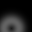

In [197]:
Image.fromarray((gaussian_distr_ring() * 100).astype(np.uint8))

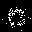

In [235]:
N = 32
ring_prob = gaussian_distr_ring(32, 10000)
img_coor = np.array([[(i, j) for i in range(32)] for j in range(32)], dtype=np.int32)
activated_pmts = img_coor.reshape((N * N, 2))[np.random.choice(np.arange(N * N), 100, p=ring_prob.flatten() / ring_prob.sum())]
img = np.zeros_like(ring_prob, dtype=np.bool)
img[activated_pmts[:, 0], activated_pmts[:, 1]] = 1
Image.fromarray(img)

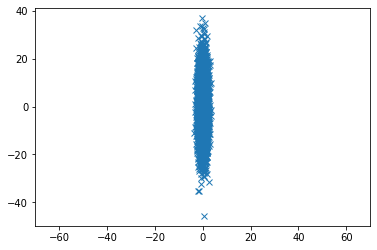

In [5]:
def random_ring(ring_prob):
    n

    img = np.zeros_like(radius, dtype=np.bool)
    img[np.logical_and(radius >= self.inners[width_idx], radius < self.outers[width_idx])] = 1

    features = np.array([center[0], center[1], self.inners[width_idx], self.outers[width_idx]]).reshape(1, -1)
    features = torch.tensor(self.scaler.transform(features), dtype=torch.float)

    return features, img

In [3]:
generator = ConvGenerator(dataset_generator.n_features, img_size=32)
generator.load_state_dict(torch.load('./save_model/naive_conv.pt'))

NameError: name 'dataset_generator' is not defined

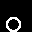

In [25]:
features, img = ring_gen.random_ring()
Image.fromarray(img)

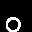

In [26]:
img_pred = generator(features).detach().numpy().squeeze() > 0.5
Image.fromarray(img_pred)

In [ ]:
img = generator(torch.tensor([[15, 15, 5, 10]], dtype=torch.float)).detach().numpy().squeeze()

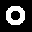

In [57]:
Image.fromarray(create_ring_img(32, (15, 15), 5, 10))